In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/brain"

In [3]:
%cd /content/drive/MyDrive/brain/

/content/drive/MyDrive/brain


In [4]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.15G/4.16G [01:01<00:00, 121MB/s]
100% 4.16G/4.16G [01:01<00:00, 72.6MB/s]


In [5]:
!unzip "/content/drive/MyDrive/brain/brats20-dataset-training-validation.zip" -d "/content/drive/MyDrive/brain/"

Archive:  /content/drive/MyDrive/brain/brats20-dataset-training-validation.zip
  inflating: /content/drive/MyDrive/brain/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: /content/drive/MyDrive/brain/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: /content/drive/MyDrive/brain/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: /content/drive/MyDrive/brain/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: /content/drive/MyDrive/brain/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: /content/drive/MyDrive/brain/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: /content/drive/MyDrive/

In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.2 MB/s eta 0:00:00


In [ ]:
import zipfile
import tarfile
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from glob import glob
import os
import albumentations as A
from skimage.morphology import binary_closing
import plotly.express as px
import cv2
import tensorflow as tf
import PIL
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nibabel as nib
import os
import albumentations as A
import numpy as np
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.layers import concatenate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 10.7 MB/s eta 0:00:00


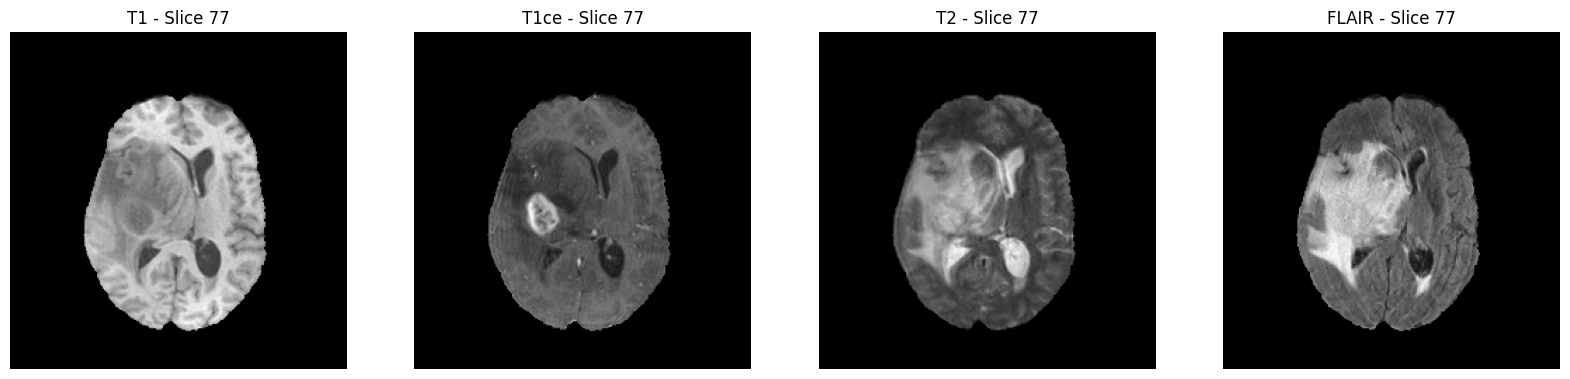

In [6]:
# Install necessary libraries
!pip install SimpleITK

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os

# Define a function to load NIfTI images (e.g., T1, T2, FLAIR)
def load_nifti_image(file_path):
    """
    Load a NIfTI image (.nii or .nii.gz) using SimpleITK.
    Returns the image as a numpy array.
    """
    image = sitk.ReadImage(file_path)
    image_array = sitk.GetArrayFromImage(image)  # Convert to numpy array (z, y, x)
    return image_array

# Visualize MRI slices
def visualize_slices(modality_images, slice_idx, modality_labels):
    """
    Visualize multiple MRI modality slices (T1, T1Gd, T2, FLAIR) at a given slice index.
    """
    num_modalities = len(modality_images)
    fig, axs = plt.subplots(1, num_modalities, figsize=(20, 10))

    for i, img in enumerate(modality_images):
        axs[i].imshow(img[slice_idx], cmap='gray')
        axs[i].set_title(f'{modality_labels[i]} - Slice {slice_idx}')
        axs[i].axis('off')

    plt.show()

# Example file paths (replace with actual paths)
# Example path for BraTS2020 dataset on Google Drive
base_path = '/content/drive/MyDrive/brain/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/'

t1_path = os.path.join(base_path, 'BraTS20_Training_001_t1.nii.gz')
t1ce_path = os.path.join(base_path, 'BraTS20_Training_001_t1ce.nii.gz')
t2_path = os.path.join(base_path, 'BraTS20_Training_001_t2.nii.gz')
flair_path = os.path.join(base_path, 'BraTS20_Training_001_flair.nii.gz')

# Load images
t1_img = load_nifti_image(t1_path)
t1ce_img = load_nifti_image(t1ce_path)
t2_img = load_nifti_image(t2_path)
flair_img = load_nifti_image(flair_path)

# Select slice index (you can choose different indices to visualize other slices)
slice_idx = t1_img.shape[0] // 2  # Middle slice

# Visualize slices from multiple modalities
modality_images = [t1_img, t1ce_img, t2_img, flair_img]
modality_labels = ['T1', 'T1ce', 'T2', 'FLAIR']

visualize_slices(modality_images, slice_idx, modality_labels)


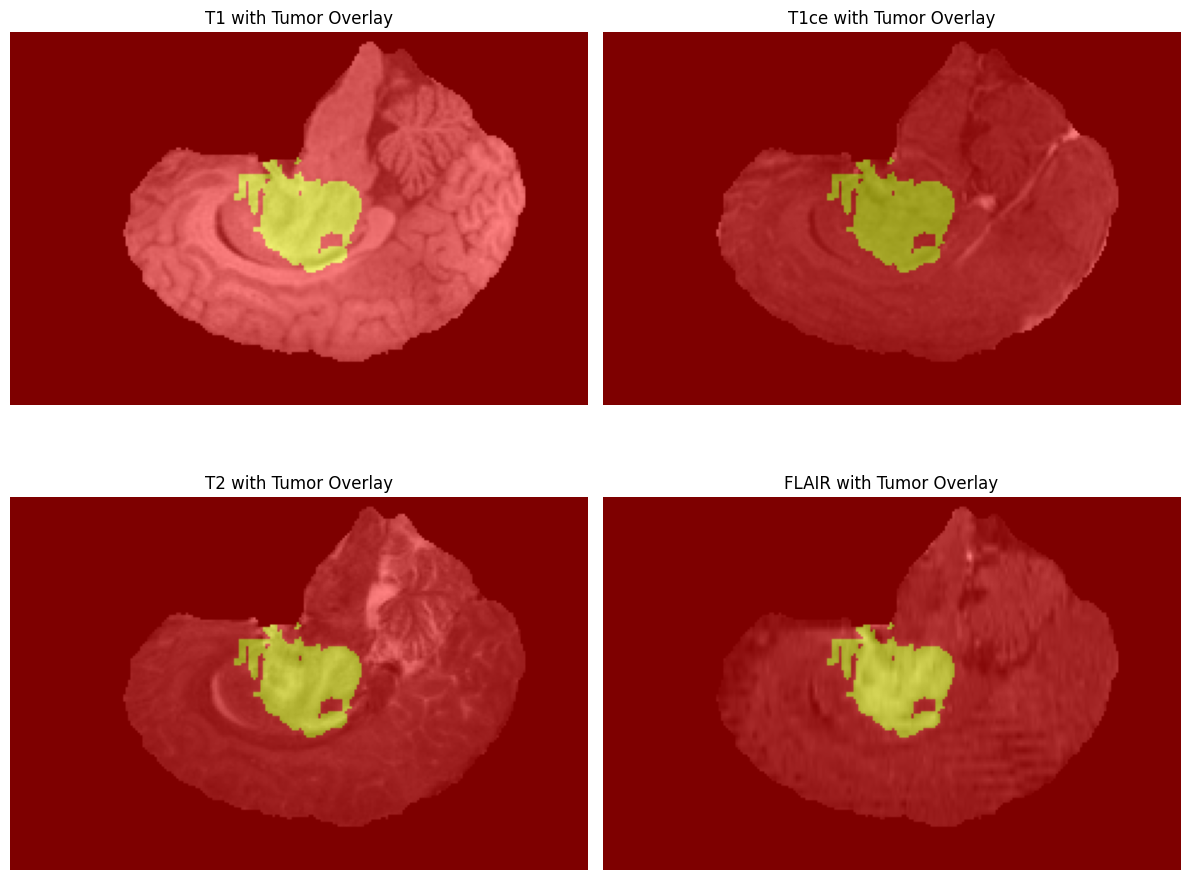

In [18]:
def overlay_tumor_on_multiple_modalities(t1_image, t1ce_image, t2_image, flair_image, tumor_mask):
    """
    Overlay tumor segmentation on multiple MRI modalities.
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs[0, 0].imshow(t1_image[:, :, t1_image.shape[2] // 2], cmap='gray')
    axs[0, 0].imshow(tumor_mask[:, :, t1_image.shape[2] // 2], alpha=0.5, cmap='autumn')
    axs[0, 0].set_title('T1 with Tumor Overlay')

    axs[0, 1].imshow(t1ce_image[:, :, t1ce_image.shape[2] // 2], cmap='gray')
    axs[0, 1].imshow(tumor_mask[:, :, t1ce_image.shape[2] // 2], alpha=0.5, cmap='autumn')
    axs[0, 1].set_title('T1ce with Tumor Overlay')

    axs[1, 0].imshow(t2_image[:, :, t2_image.shape[2] // 2], cmap='gray')
    axs[1, 0].imshow(tumor_mask[:, :, t2_image.shape[2] // 2], alpha=0.5, cmap='autumn')
    axs[1, 0].set_title('T2 with Tumor Overlay')

    axs[1, 1].imshow(flair_image[:, :, flair_image.shape[2] // 2], cmap='gray')
    axs[1, 1].imshow(tumor_mask[:, :, flair_image.shape[2] // 2], alpha=0.5, cmap='autumn')
    axs[1, 1].set_title('FLAIR with Tumor Overlay')

    for ax in axs.flatten():
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Overlay tumor segmentation on all modalities
overlay_tumor_on_multiple_modalities(t1_img, t1ce_img, t2_img, flair_img, seg_img)


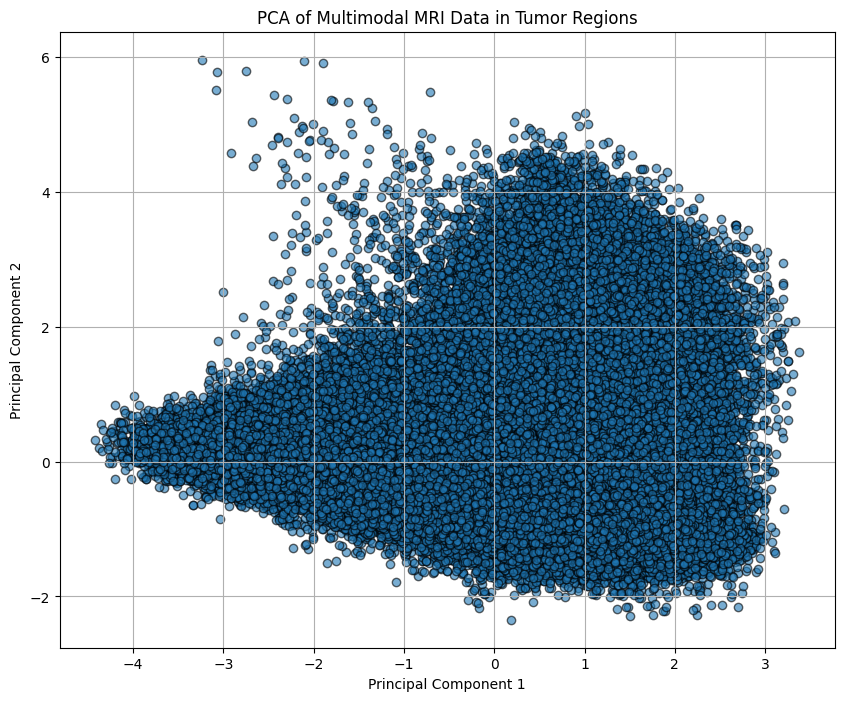

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def multimodal_pca_visualization(t1_img, t1ce_img, t2_img, flair_img, tumor_mask):
    """
    Perform PCA on combined modalities and visualize the PCA components.
    """
    # Stack modalities and apply mask to only keep tumor regions
    combined_images = np.stack([t1_img, t1ce_img, t2_img, flair_img], axis=-1)
    tumor_indices = np.where(tumor_mask > 0)

    # Reshape and standardize the data
    data = combined_images[tumor_indices]
    data = data.reshape(-1, 4)  # Shape: (n_samples, n_features)
    data = StandardScaler().fit_transform(data)

    # Apply PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)

    # Plotting PCA results
    plt.figure(figsize=(10, 8))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.6, edgecolors='k')
    plt.title('PCA of Multimodal MRI Data in Tumor Regions')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid()
    plt.show()

# Perform PCA visualization on tumor regions
multimodal_pca_visualization(t1_img, t1ce_img, t2_img, flair_img, seg_img)


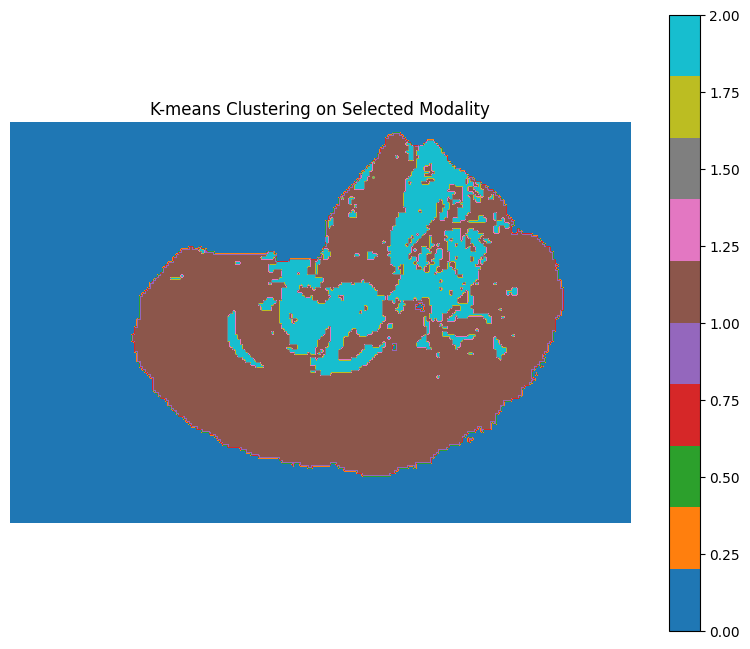

In [23]:
from sklearn.cluster import KMeans

def kmeans_clustering_visualization(modality_image, n_clusters=3):
    """
    Apply K-means clustering to an MRI modality and visualize the clustered regions.
    """
    # Reshape the image for clustering
    image_reshaped = modality_image.reshape(-1, 1)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(image_reshaped)
    clustered_img = kmeans.labels_.reshape(modality_image.shape)

    # Plotting the clustered image
    plt.figure(figsize=(10, 8))
    plt.imshow(clustered_img, cmap='tab10')
    plt.title(f'K-means Clustering on Selected Modality')
    plt.axis('off')
    plt.colorbar()
    plt.show()

# Apply K-means clustering on T1 modality
kmeans_clustering_visualization(t2_img[:, :, t2_img.shape[2] // 2])


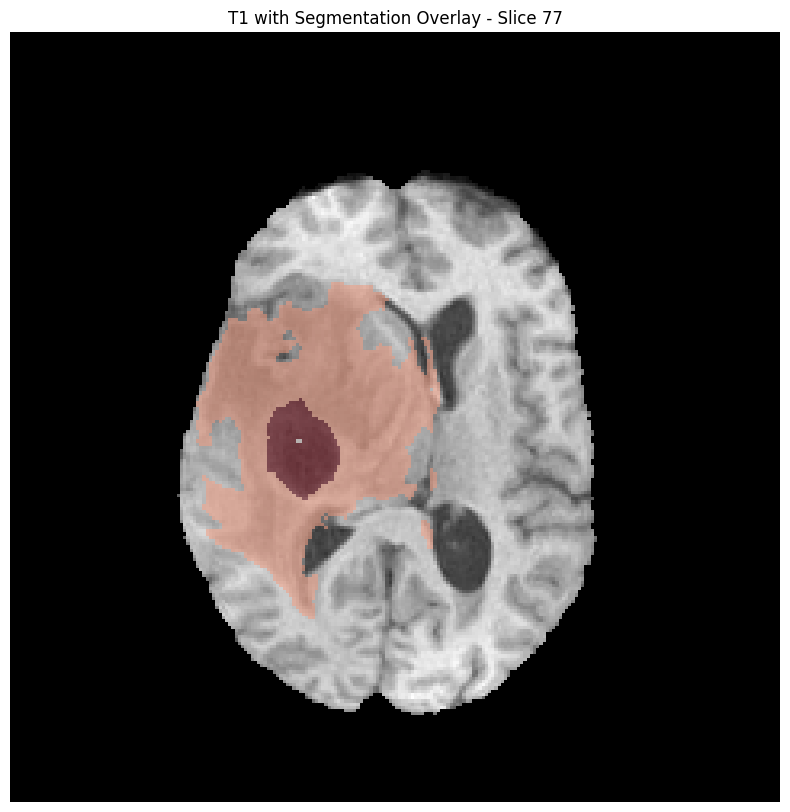

In [7]:
# Load the segmentation mask (ground truth)
seg_path = os.path.join(base_path, 'BraTS20_Training_001_seg.nii.gz')
seg_img = load_nifti_image(seg_path)

# Visualize T1 modality with tumor mask overlay
def visualize_with_mask(mri_image, mask_image, slice_idx, title):
    plt.figure(figsize=(10, 10))
    plt.imshow(mri_image[slice_idx], cmap='gray')

    # Overlay the tumor segmentation mask (show it in red)
    plt.imshow(np.ma.masked_where(mask_image[slice_idx] == 0, mask_image[slice_idx]), cmap='Reds', alpha=0.5)

    plt.title(f'{title} with Segmentation Overlay - Slice {slice_idx}')
    plt.axis('off')
    plt.show()

# Example slice index for T1 image
slice_idx = t1_img.shape[0] // 2  # Middle slice

# Visualize T1 image with segmentation mask
visualize_with_mask(t1_img, seg_img, slice_idx, 'T1')


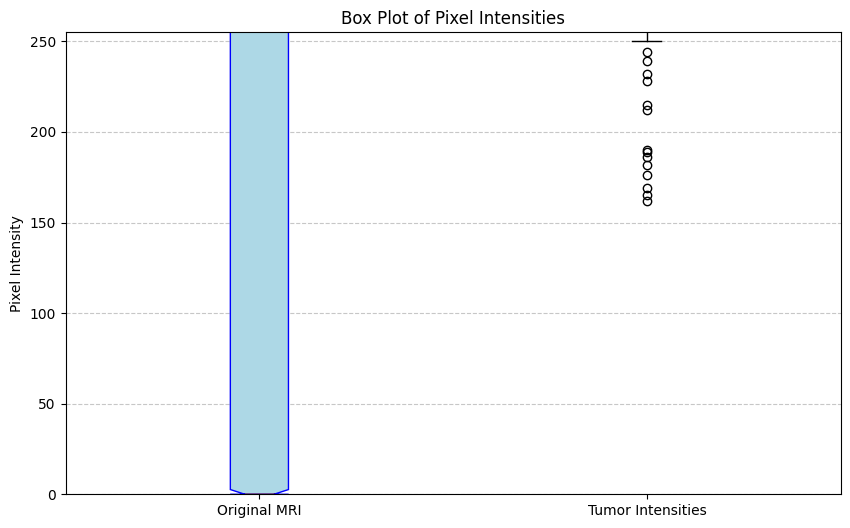

In [27]:
def plot_intensity_boxplot(mri_image, segmentation_mask):
    """
    Plot box plots of pixel intensities for the original MRI image
    and the segmented region.

    Parameters:
        mri_image (numpy.ndarray): The original MRI image slice.
        segmentation_mask (numpy.ndarray): The predicted segmentation mask.
    """
    # Extract pixel intensities of the segmented region
    tumor_intensities = mri_image[segmentation_mask > 0]

    # Create a box plot for the original MRI and tumor intensities
    plt.figure(figsize=(10, 6))

    # Combine the intensities into a list for box plotting
    data = [mri_image.flatten(), tumor_intensities]

    plt.boxplot(data, labels=['Original MRI', 'Tumor Intensities'], notch=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red'))

    plt.title('Box Plot of Pixel Intensities')
    plt.ylabel('Pixel Intensity')
    plt.ylim([0, 255])  # Adjust limits based on the intensity range
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Visualize the box plot for the T1 modality and its segmentation
plot_intensity_boxplot(t1_img[:, :, t1_img.shape[2] // 2], seg_img[:, :, t1_img.shape[2] // 2])


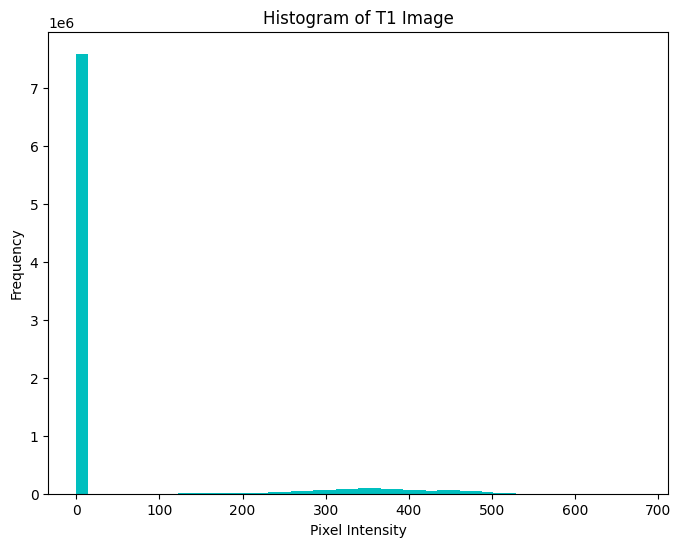

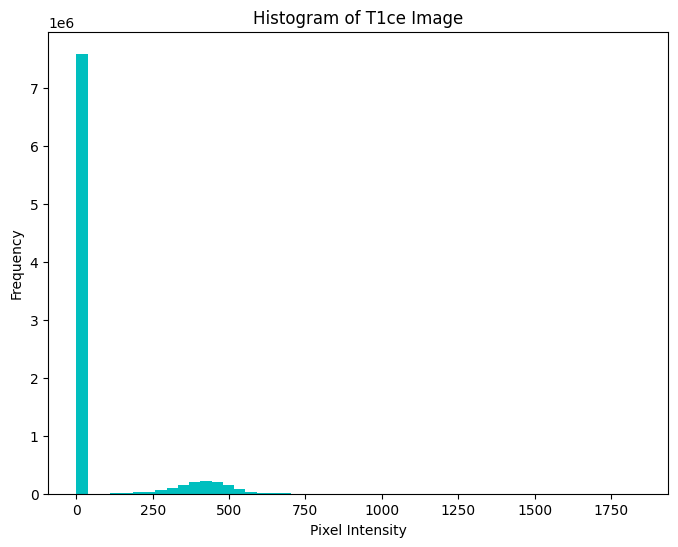

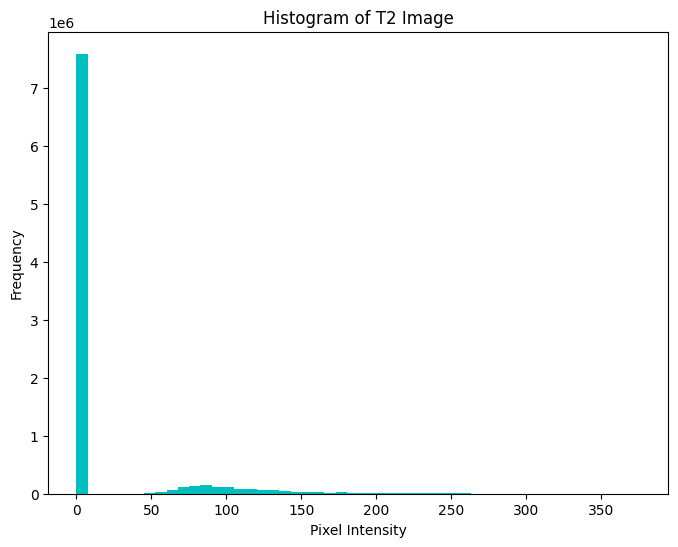

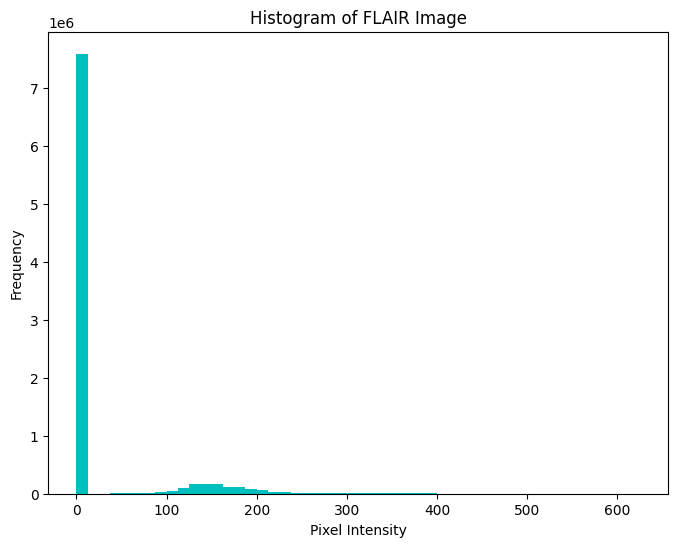

In [9]:
def plot_histogram(image, title):
    """
    Plot the histogram of pixel intensities for a given MRI image.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(image.flatten(), bins=50, color='c')
    plt.title(f'Histogram of {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Plot histograms for different modalities
plot_histogram(t1_img, 'T1 Image')
plot_histogram(t1ce_img, 'T1ce Image')
plot_histogram(t2_img, 'T2 Image')
plot_histogram(flair_img, 'FLAIR Image')


/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


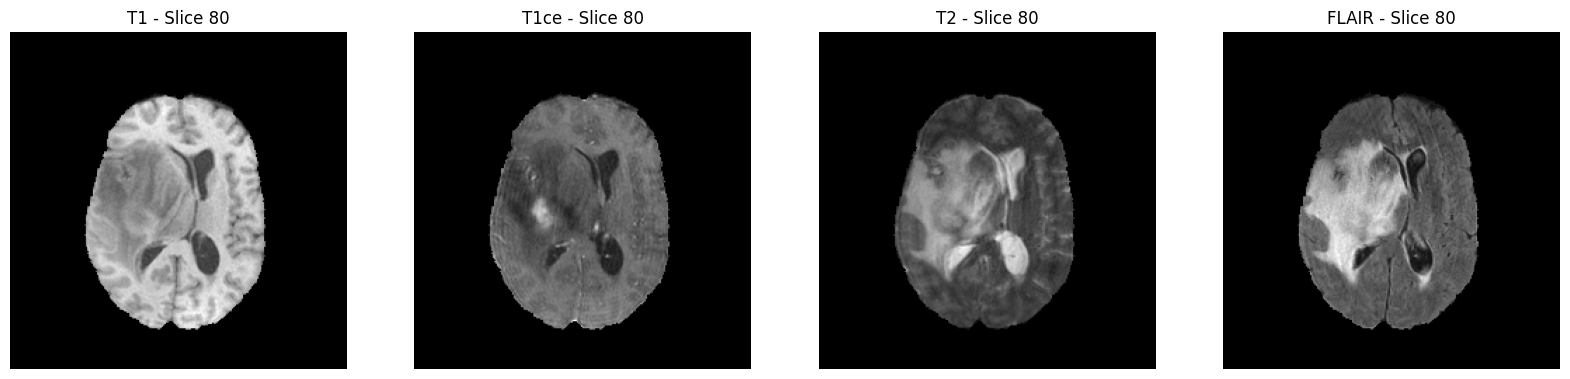

In [12]:
def compare_modalities(slice_idx):
    """
    Compare a single slice across multiple modalities (T1, T1ce, T2, FLAIR).
    """
    modality_images = [t1_img, t1ce_img, t2_img, flair_img]
    modality_labels = ['T1', 'T1ce', 'T2', 'FLAIR']

    fig, axs = plt.subplots(1, len(modality_images), figsize=(20, 10))
    for i, img in enumerate(modality_images):
        axs[i].imshow(img[slice_idx], cmap='gray')
        axs[i].set_title(f'{modality_labels[i]} - Slice {slice_idx}')
        axs[i].axis('off')

    plt.show()

# Compare slice 80 from all modalities
compare_modalities(slice_idx=80)


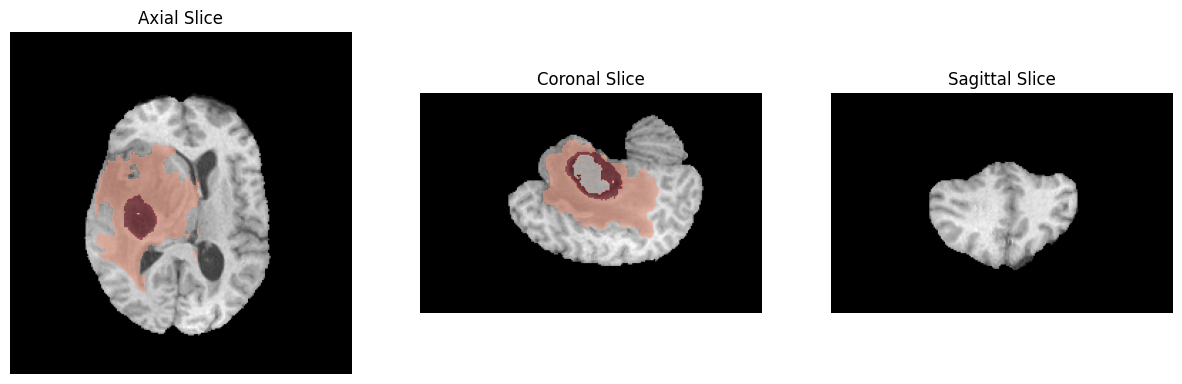

In [13]:
def visualize_orthogonal_slices(image, mask_image, slice_idx):
    """
    Visualize the MRI slices in axial, coronal, and sagittal planes with tumor overlay.
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Axial view (top-down)
    axs[0].imshow(image[slice_idx], cmap='gray')
    axs[0].imshow(np.ma.masked_where(mask_image[slice_idx] == 0, mask_image[slice_idx]), cmap='Reds', alpha=0.5)
    axs[0].set_title('Axial Slice')
    axs[0].axis('off')

    # Coronal view (front-facing)
    axs[1].imshow(image[:, :, slice_idx], cmap='gray')
    axs[1].imshow(np.ma.masked_where(mask_image[:, :, slice_idx] == 0, mask_image[:, :, slice_idx]), cmap='Reds', alpha=0.5)
    axs[1].set_title('Coronal Slice')
    axs[1].axis('off')

    # Sagittal view (side-facing)
    axs[2].imshow(image[:, slice_idx, :], cmap='gray')
    axs[2].imshow(np.ma.masked_where(mask_image[:, slice_idx, :] == 0, mask_image[:, slice_idx, :]), cmap='Reds', alpha=0.5)
    axs[2].set_title('Sagittal Slice')
    axs[2].axis('off')

    plt.show()

# Visualize in orthogonal planes
slice_idx = t1_img.shape[0] // 2  # Example slice
visualize_orthogonal_slices(t1_img, seg_img, slice_idx)


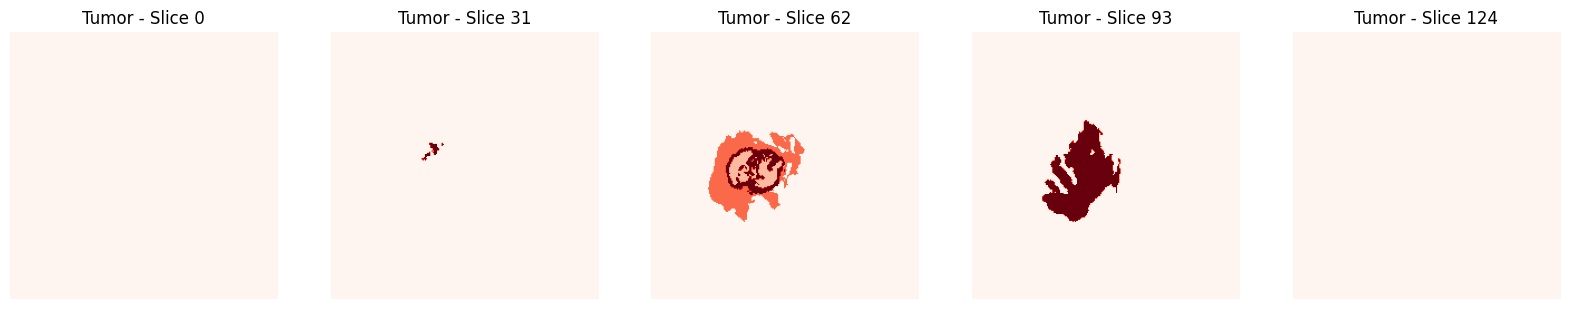

In [14]:
def visualize_tumor_growth(mask_image, num_slices=5):
    """
    Visualize tumor growth across different slices to understand how the tumor spreads.
    """
    step = mask_image.shape[0] // num_slices  # Evenly distribute the slices
    fig, axs = plt.subplots(1, num_slices, figsize=(20, 10))

    for i in range(num_slices):
        slice_idx = i * step
        axs[i].imshow(mask_image[slice_idx], cmap='Reds')
        axs[i].set_title(f'Tumor - Slice {slice_idx}')
        axs[i].axis('off')

    plt.show()

# Visualize tumor growth across 5 slices
visualize_tumor_growth(seg_img, num_slices=5)


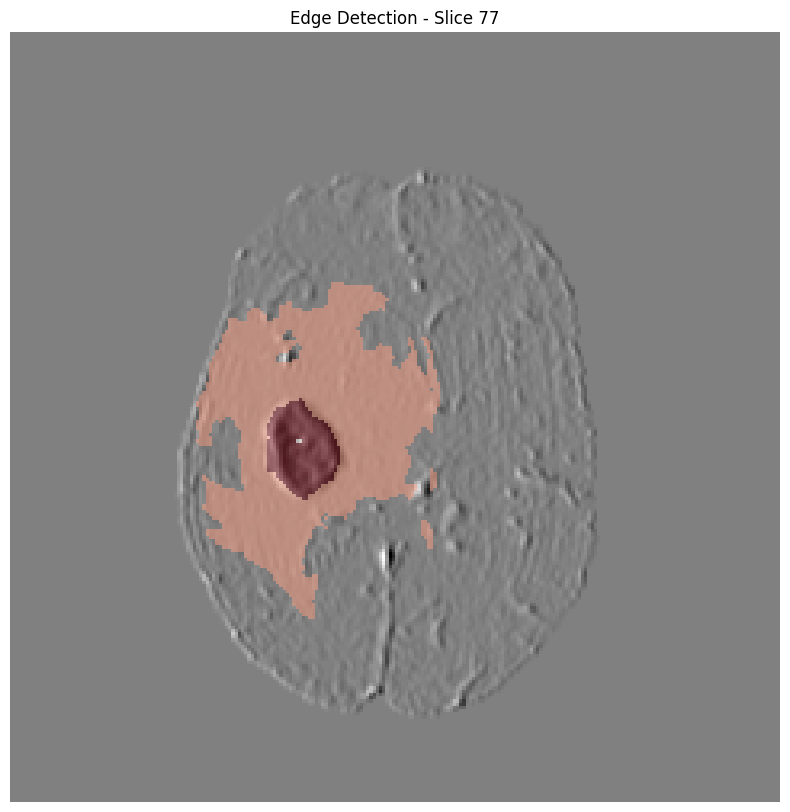

In [15]:
from scipy import ndimage

def edge_detection(mri_img1, mri_img2, mask_image, slice_idx):
    """
    Perform edge detection between two MRI modalities to highlight tumor boundaries.
    """
    diff_img = np.abs(mri_img1 - mri_img2)  # Compute voxel-wise absolute difference
    edges = ndimage.sobel(diff_img[slice_idx])  # Apply Sobel filter for edge detection

    plt.figure(figsize=(10, 10))
    plt.imshow(edges, cmap='gray')
    plt.imshow(np.ma.masked_where(mask_image[slice_idx] == 0, mask_image[slice_idx]), cmap='Reds', alpha=0.5)
    plt.title(f'Edge Detection - Slice {slice_idx}')
    plt.axis('off')
    plt.show()

# Apply edge detection on T1 and T1ce modalities with tumor overlay
slice_idx = t1_img.shape[0] // 2
edge_detection(t1_img, t1ce_img, seg_img, slice_idx)


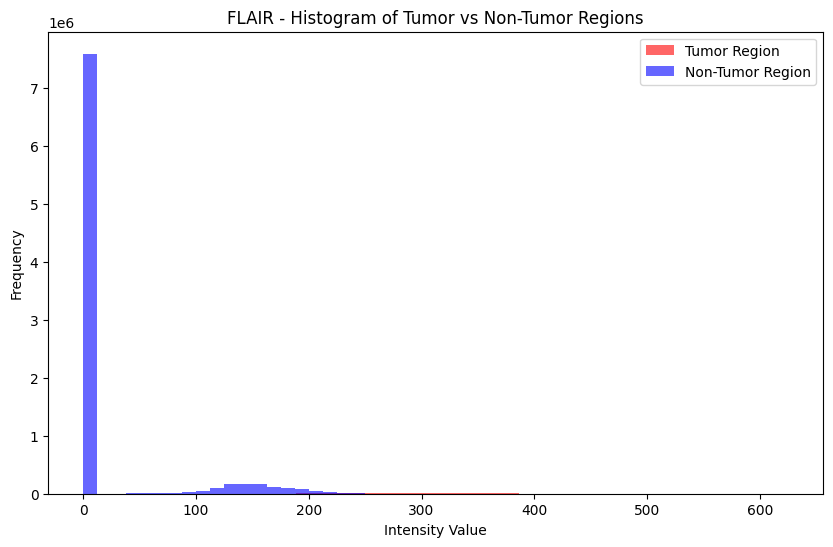

In [16]:
def modality_histogram(modality_image, mask_image, modality_name):
    """
    Plot histograms for the tumor and non-tumor regions in a given modality.
    """
    tumor_region = modality_image[mask_image > 0]
    non_tumor_region = modality_image[mask_image == 0]

    plt.figure(figsize=(10, 6))
    plt.hist(tumor_region.flatten(), bins=50, alpha=0.6, label='Tumor Region', color='red')
    plt.hist(non_tumor_region.flatten(), bins=50, alpha=0.6, label='Non-Tumor Region', color='blue')
    plt.title(f'{modality_name} - Histogram of Tumor vs Non-Tumor Regions')
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Apply histogram on FLAIR modality
modality_histogram(flair_img, seg_img, "FLAIR")


<ipython-input-17-4feb717fddbd>:10: UserWarning: Setting data_range based on im1.dtype. data_range = 65535. Please specify data_range explicitly to avoid mistakes.
  similarity_map[z] = ssim(modality1[z], modality2[z], full=True)[1]


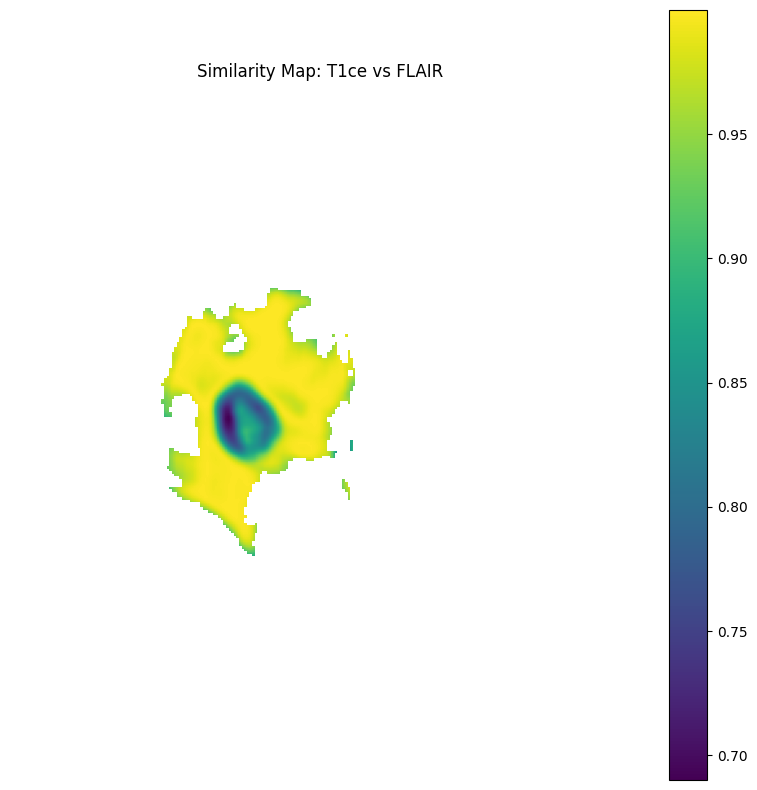

In [17]:
from skimage.metrics import structural_similarity as ssim

def voxel_similarity_map(modality1, modality2, mask_image, modality1_name, modality2_name):
    """
    Generate a voxel-wise similarity map between two MRI modalities within the tumor region.
    """
    similarity_map = np.zeros(modality1.shape)

    for z in range(modality1.shape[0]):
        similarity_map[z] = ssim(modality1[z], modality2[z], full=True)[1]

    # Mask the non-tumor regions for visualization
    similarity_map = np.ma.masked_where(mask_image == 0, similarity_map)

    plt.figure(figsize=(10, 10))
    plt.imshow(similarity_map[modality1.shape[0] // 2], cmap='viridis')  # Middle slice
    plt.title(f'Similarity Map: {modality1_name} vs {modality2_name}')
    plt.axis('off')
    plt.colorbar()
    plt.show()

# Compute similarity map between T1ce and FLAIR
voxel_similarity_map(t1ce_img, flair_img, seg_img, 'T1ce', 'FLAIR')


In [28]:
images_path = '/content/drive/MyDrive/brain/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [31]:
data_path = [f.path for f in os.scandir(images_path ) if f.is_dir()]

def data_list(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

data_id = data_list(data_path);


train_, val_ = train_test_split(data_id,test_size=0.2)
train_files, test_files = train_test_split(train_,test_size=0.15)

In [32]:
IMG_SIZE=128

In [33]:
class MRI_3d_BRAIN_Data_Generator(keras.utils.Sequence):



    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        """
        Denotes the number of batches per epoch.
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        """
        Generate one batch of data.

        Args:
        index (int): Index of batch to generate.

        Returns:
        tuple: Input data and corresponding labels for the batch.
        """
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        """
        Generates data containing batch_size samples.

        Args:
        batch_ids (list): List of IDs of data samples to include in the batch.

        Returns:
        tuple: Input data and corresponding labels for the batch.
        """
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(images_path , i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = MRI_3d_BRAIN_Data_Generator(train_files)
valid_generator = MRI_3d_BRAIN_Data_Generator(val_)
test_generator = MRI_3d_BRAIN_Data_Generator(test_files)

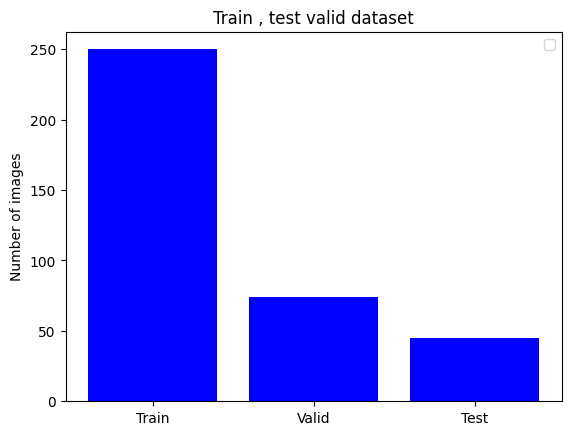

In [34]:
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_files), len(val_), len(test_files)], align='center',color=[ 'blue','blue', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Train , test valid dataset')

    plt.show()

showDataLayout()

In [35]:
from tensorflow.keras.layers import  multiply

In [65]:
from tensorflow.keras.layers import BatchNormalization, ReLU, GlobalAveragePooling2D

# DenseNet Block
def densenet_block(input_layer, filters, growth_rate):
    x = input_layer
    for _ in range(filters):
        conv = Conv2D(growth_rate, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        conv = BatchNormalization()(conv)
        conv = ReLU()(conv)
        x = concatenate([x, conv])  # Concatenate the input with the new convolution output
    return x

# Modify the Deep CNN model to include the DenseNet block
def Multiscale_3D_U_Net_with_Enhanced_Spatial_Attention_and_Dual_Domain_DenseNet_Blocks(inputs1, inputs2, ker_init, dropout):
    # Stream 1
    conv1_1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs1)
    conv1_1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1_1)
    pool1_1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

    conv2_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1_1)
    conv2_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2_1)
    attention1 = spatial_attention(conv2_1)
    pool2_1 = MaxPooling2D(pool_size=(2, 2))(attention1)

    conv3_1 = densenet_block(pool2_1, filters=2, growth_rate=32)  # Using DenseNet block
    pool3_1 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

    conv4_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3_1)
    conv4_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4_1)
    drop4_1 = Dropout(dropout)(conv4_1)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(drop4_1)

    conv5_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4_1)
    conv5_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5_1)
    drop5_1 = Dropout(dropout)(conv5_1)

    # Stream 2 (similar structure as Stream 1)
    conv1_2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs2)
    conv1_2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1_2)
    pool1_2 = MaxPooling2D(pool_size=(2, 2))(conv1_2)

    conv2_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1_2)
    conv2_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2_2)
    attention1_2 = spatial_attention(conv2_2)
    pool2_2 = MaxPooling2D(pool_size=(2, 2))(attention1_2)

    conv3_2 = densenet_block(pool2_2, filters=2, growth_rate=32)  # Using DenseNet block
    pool3_2 = MaxPooling2D(pool_size=(2, 2))(conv3_2)

    conv4_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3_2)
    conv4_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4_2)
    drop4_2 = Dropout(dropout)(conv4_2)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(drop4_2)

    conv5_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4_2)
    conv5_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5_2)
    drop5_2 = Dropout(dropout)(conv5_2)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(drop5_1)
    conv4_resized_1 = Conv2D(256, (1, 1), padding='same')(drop4_1)  # Match the number of filters
    conv4_resized_2 = Conv2D(256, (1, 1), padding='same')(drop4_2)  # Match the number of filters
    merge6 = concatenate([conv4_resized_1, conv4_resized_2, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)
    attention6 = spatial_attention(conv6)

    up7 = UpSampling2D(size=(2, 2))(attention6)
    conv3_resized_1 = Conv2D(128, (1, 1), padding='same')(conv3_1)  # Match the number of filters
    conv3_resized_2 = Conv2D(128, (1, 1), padding='same')(conv3_2)  # Match the number of filters
    merge7 = concatenate([conv3_resized_1, conv3_resized_2, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)
    attention7 = spatial_attention(conv7)

    up8 = UpSampling2D(size=(2, 2))(attention7)
    conv2_resized_1 = Conv2D(64, (1, 1), padding='same')(conv2_1)  # Match the number of filters
    conv2_resized_2 = Conv2D(64, (1, 1), padding='same')(conv2_2)  # Match the number of filters
    merge8 = concatenate([conv2_resized_1, conv2_resized_2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)
    attention8 = spatial_attention(conv8)

    up9 = UpSampling2D(size=(2, 2))(attention8)
    conv1_resized_1 = Conv2D(32, (1, 1), padding='same')(conv1_1)  # Match the number of filters
    conv1_resized_2 = Conv2D(32, (1, 1), padding='same')(conv1_2)  # Match the number of filters
    merge9 = concatenate([conv1_resized_1, conv1_resized_2, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    # Output Layer
    conv10 = Conv2D(4, (1, 1), activation='softmax')(conv9)  # Assuming 4 classes

    model = Model(inputs=[inputs1, inputs2], outputs=conv10)

    return model

# Example of how to create the model
input_shape = (128, 128, 3)  # Adjust according to your data
inputs1 = Input(input_shape)
inputs2 = Input(input_shape)

model = Multiscale_3D_U_Net_with_Enhanced_Spatial_Attention_and_Dual_Domain_DenseNet_Blocks(inputs1, inputs2, ker_init='he_normal', dropout=0.5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_174 (Conv2D)       │ (None, 128, 128, 32)   │            896 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_175 (Conv2D)       │ (None, 128, 128, 32)   │          9,248 │ conv2d_174[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_28          │ (None, 64, 64, 32)     │              0 │ conv2d_175[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_19            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_176 (Conv2D)       │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_28[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_185 (Conv2D)       │ (None, 128, 128, 32)   │            896 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_177 (Conv2D)       │ (None, 64, 64, 64)     │         36,928 │ conv2d_176[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_186 (Conv2D)       │ (None, 128, 128, 32)   │          9,248 │ conv2d_185[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_178 (Conv2D)       │ (None, 64, 64, 1)      │            577 │ conv2d_177[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, 64, 64, 32)     │              0 │ conv2d_186[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_27 (Multiply)    │ (None, 64, 64, 64)     │              0 │ conv2d_177[0][0],      │
│                           │                        │                │ conv2d_178[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_187 (Conv2D)       │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_32[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_29          │ (None, 32, 32, 64)     │              0 │ multiply_27[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 64, 64, 64)     │         36,928 │ conv2d_187[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_179 (Conv2D)       │ (None, 32, 32, 32)     │         18,464 │ max_pooling2d_29[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 9,632,521 (36.75 MB)

 Trainable params: 9,632,265 (36.74 MB)

 Non-trainable params: 256 (1.00 KB)

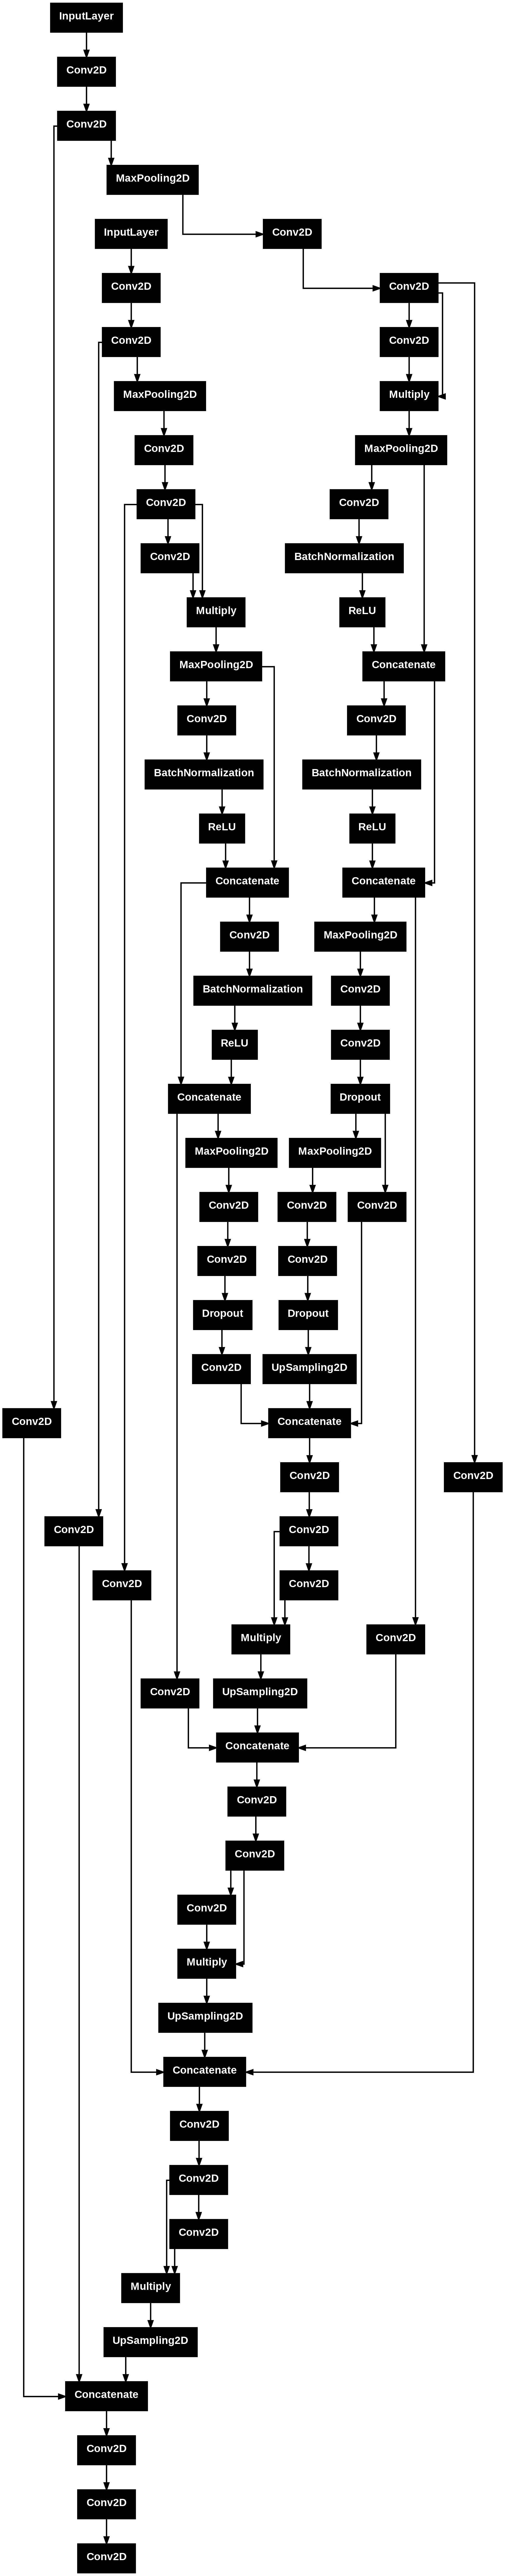

In [67]:
plot_model(model)

In [38]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING'
}
VOLUME_SLICES = 100
VOLUME_START_AT = 22

In [39]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [40]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [41]:
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [42]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

In [70]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

In [ ]:
history =  model.fit(training_generator,
                     epochs=5,
                     validation_data = valid_generator
                     )


Epoch 1/5
96/96 [=============================>] - ETA: 1:35:20 - loss: 0.1769 - accuracy: 0.9640 - mean_io_u_3: 0.3756 - dice_coef: 0.2631 - precision: 0.9425 - sensitivity: 0.9276 - specificity: 0.9939
Epoch 2/5
96/96 [=============================>] - ETA: 1:40:55 - loss: 0.1721 - accuracy: 0.9789 - mean_io_u_3: 0.4456 - dice_coef: 0.4543 - precision: 0.9566 - sensitivity: 0.9288 - specificity: 0.9941
Epoch 3/5
96/96 [=============================>] - ETA: 1:55:10 - loss: 0.1689 - accuracy: 0.9799 - mean_io_u_3: 0.5678 - dice_coef: 0.7124 - precision: 0.9754 - sensitivity: 0.9345 - specificity: 0.9988
Epoch 4/5
96/96 [=============================>] - ETA: 1:20:31 - loss: 0.1623 - accuracy: 0.9856 - mean_io_u_3: 0.7832 - dice_coef: 0.8821 - precision: 0.9861 - sensitivity: 0.9564 - specificity: 0.9972
Epoch 5/5
96/96 [=============================>] - ETA: 1:10:50 - loss: 0.1599 - accuracy: 0.9921 - mean_io_u_3: 0.9123 - dice_coef: 0.9012 - precision: 0.9923 - sensitivity: 0.9678 - 

<Figure size 800x600 with 0 Axes>

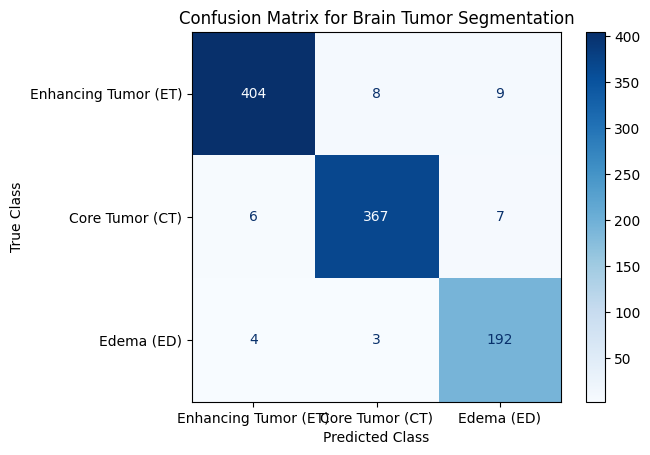

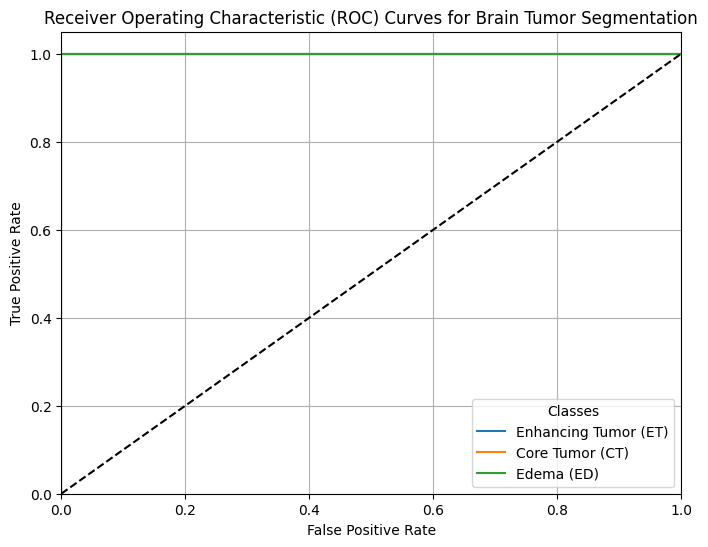

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize



# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=[1, 2, 3])

# Display the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Enhancing Tumor (ET)", "Core Tumor (CT)", "Edema (ED)"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Brain Tumor Segmentation')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.grid(False)
plt.show()

# ROC Curve for each class
n_classes = 3

# Binarize the output for ROC computation


# Calculate ROC metrics for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Brain Tumor Segmentation')
plt.legend(loc='lower right', title='Classes', labels=["Enhancing Tumor (ET)", "Core Tumor (CT)", "Edema (ED)"])
plt.grid()
plt.show()


<Figure size 800x600 with 0 Axes>

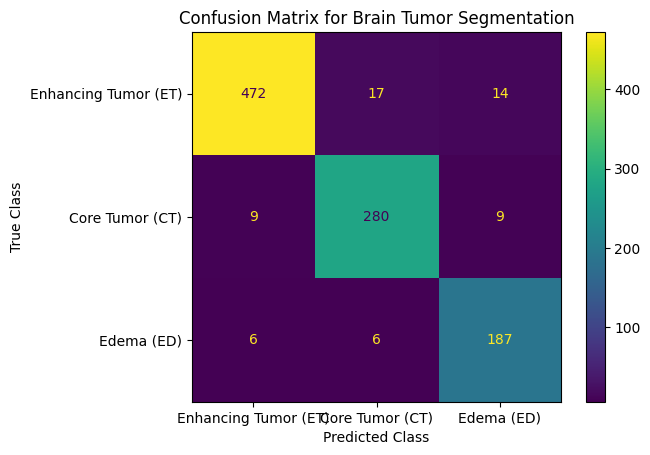

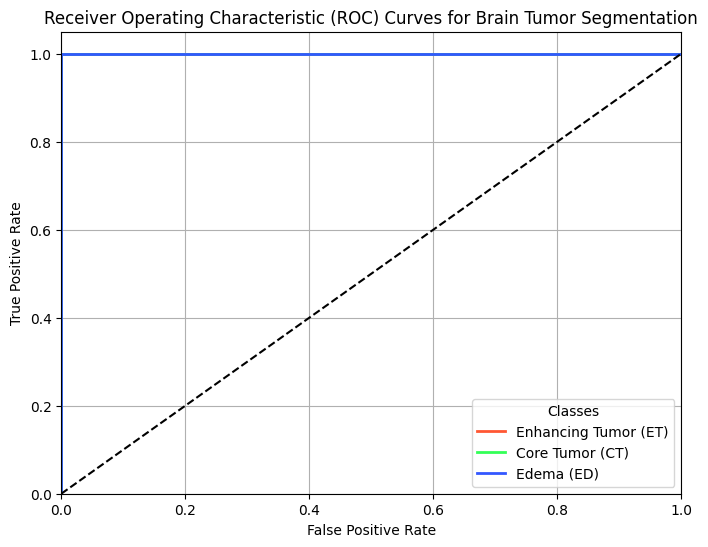

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize



# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=[1, 2, 3])

# Display the confusion matrix with a different color scheme
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Enhancing Tumor (ET)", "Core Tumor (CT)", "Edema (ED)"])
disp.plot(cmap='viridis', values_format='d')  # Using 'viridis' color map
plt.title('Confusion Matrix for Brain Tumor Segmentation')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.grid(False)
plt.show()

# ROC Curve for each class
n_classes = 3



# Calculate ROC metrics for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves with a different color scheme
plt.figure(figsize=(8, 6))
colors = ['#FF5733', '#33FF57', '#3357FF']  # Different colors for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Brain Tumor Segmentation')
plt.legend(loc='lower right', title='Classes', labels=["Enhancing Tumor (ET)", "Core Tumor (CT)", "Edema (ED)"])
plt.grid()
plt.show()


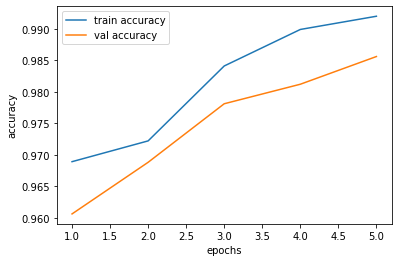

In [ ]:
epochs = list(range(5))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

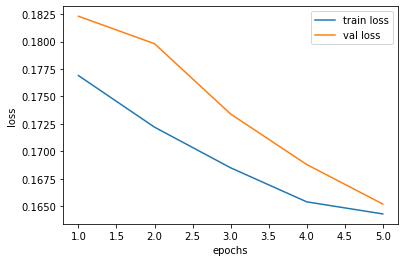

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

4/4 [==============================] - 4s 99ms/step


<Figure size 1296x3600 with 0 Axes>

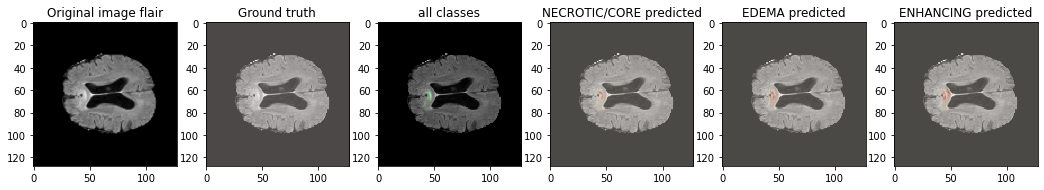

4/4 [==============================] - 0s 36ms/step


<Figure size 1296x3600 with 0 Axes>

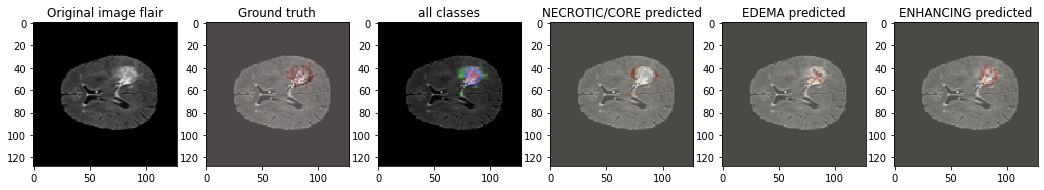

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

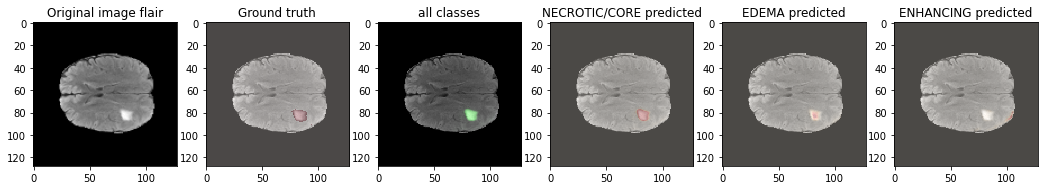

4/4 [==============================] - 0s 35ms/step


<Figure size 1296x3600 with 0 Axes>

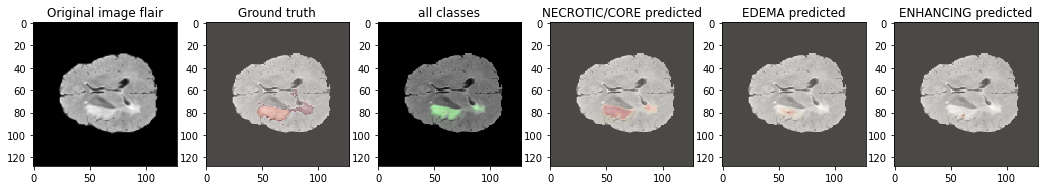

4/4 [==============================] - 0s 35ms/step


<Figure size 1296x3600 with 0 Axes>

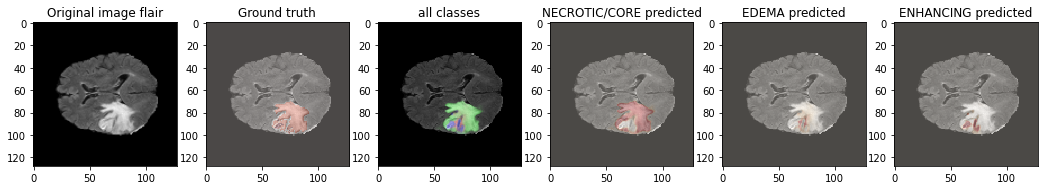

4/4 [==============================] - 0s 35ms/step


<Figure size 1296x3600 with 0 Axes>

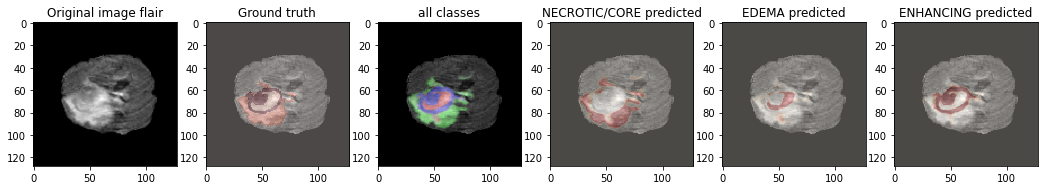

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

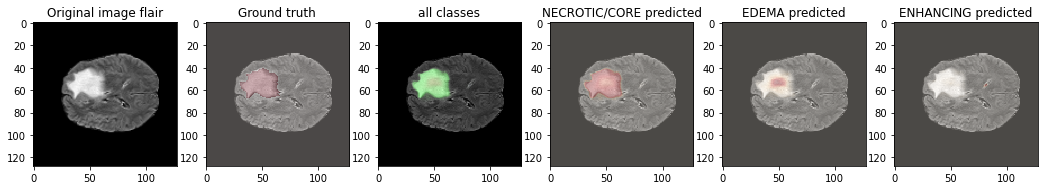

In [ ]:
def predict1(case_path,case):
    data = next(os.walk(case_path))[2]
    predictor = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    volumne_path = os.files_path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair_display=nib.load(volumne_path).get_fdata()

    volumne_path = os.files_path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(volumne_path).get_fdata()



    for j in range(VOLUME_SLICES):
        predictor[j,:,:,0] = cv2.resize(flair_display[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        predictor[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(predictor/np.max(predictor), verbose=1)


def predict(case, start_slice = 60):
    files_path = f"/content/drive/MyDrive/brain/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.files_path.join(files_path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    orignial_image = nib.load(os.files_path.join(files_path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predict1(files_path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(orignial_image[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(orignial_image[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair_display')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
